In [57]:
import os
import sys
import glob  # to pick random image from test
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [58]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

from data.data_loading import TRANSFORM, create_angle_features
from pose.pose_utils import TESTPATH, CLASS_MAPPINGS_NAMES, LANDMARKS_ANGLES_DICT, LANDMARK_DICT, calc_limb_lengths
from pose.plot import plot_image, plot_3d_keypoints, plot_distribution_with_image
from pose.pose_mediapipe import pose_landmarks_to_list, estimate_poses
from classifier.classify import classify_image
from pose.nearest_neighbor_correction import get_angle_confidence_intervals, create_pose_df, warrior_pose_front_back, \
get_annotated_img, compare_two_figures, select_correct_closest_image, which_leg_front, plot_3D, normalize_on_right_hip
from pose.decision_tree import decision_tree_correct
from gan.results_cLimbGAN import generate_coords_given_limb_lengths
from classifier.classify_pose_quality import classify_correct

### Read in Image

Note that these images are all unseen by the system in training (ie test images). They can be images that are correct or incorrect.

You can put in your own photos in the `data/test/` folder and it will get randomly picked by the code snippet below. If you wish, you can also manually set the path to your image.

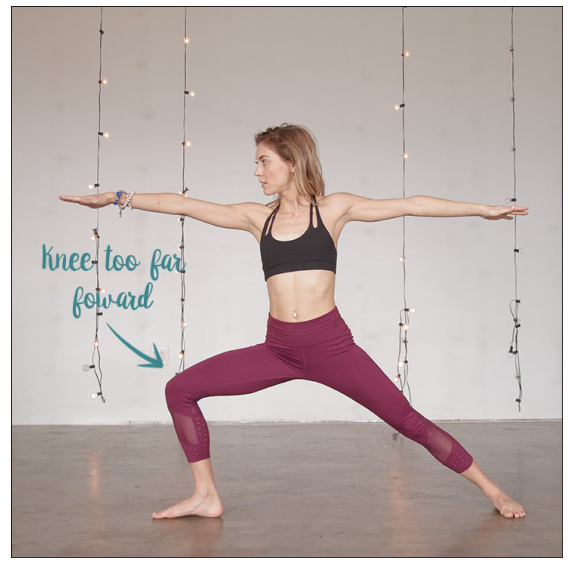

Ground Truth: 
This is a warrior2 pose
This pose is an INCORRECT pose


In [84]:
path = str(TESTPATH)
tests_images = [path for path in glob.glob(os.path.join(TESTPATH,'**','*.jpg'), recursive=True)]
CPATH = np.random.choice(tests_images)
test_image = TRANSFORM(Image.open(CPATH))
plot_image(test_image, dataloader=True)

secret_truth = CPATH.split('/')[-2].split('_')
print(f"Ground Truth: \nThis is a {secret_truth[1]} pose")
if secret_truth[0] == '0':
    print('This pose is an INCORRECT pose')
else:
    print('This pose is a Correct pose')

### Apply Pose Estimation

In [62]:
test_result, annotated_test_image = estimate_poses(test_image, CPATH, skip_image_annotation=False)

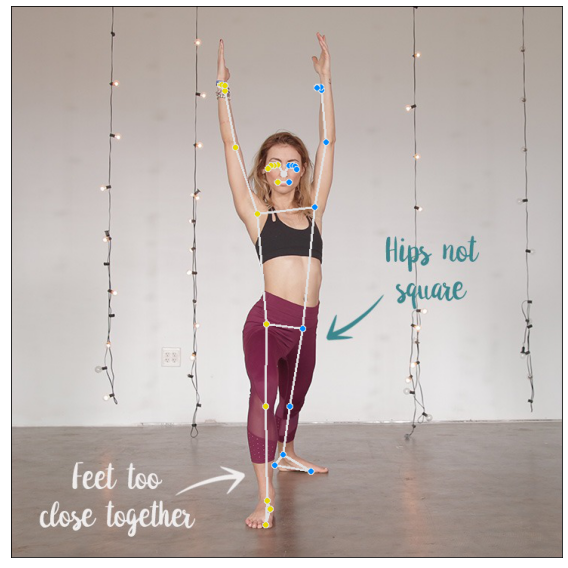

In [63]:
plot_image(annotated_test_image, dataloader=False)

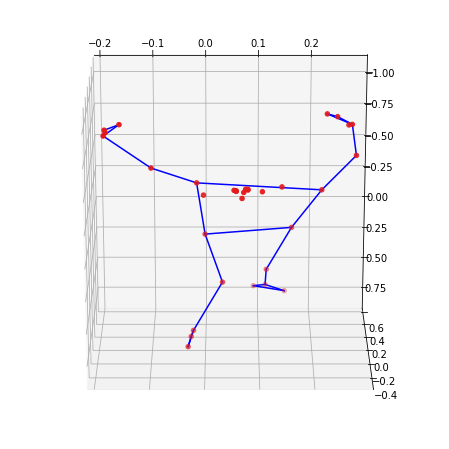

In [64]:
val, _, nump = pose_landmarks_to_list(test_result, 'pose_world_landmarks')

df_test = pd.DataFrame.from_records([val]).rename(LANDMARK_DICT, axis=1)
create_angle_features(df_test)

np_test = normalize_on_right_hip(np.array([nump]))

x = np_test[0].T[0]
y = np_test[0].T[1]
z = np_test[0].T[2]

plot_3d_keypoints(x, y, z, -70, 270)

### Pose Classification

In [65]:
label = classify_image(np_test).item()
print(f"Image Classified as : {CLASS_MAPPINGS_NAMES[label]}")
correct = classify_correct(np_test).item()
if correct < .5:
    print(f"Image is a Bad Pose")
else:
    print("Image is a Good Pose")

Image Classified as : W1
Image is a Bad Pose


In [66]:
df_w1, df_w2, df_dd = create_pose_df()
df_test_handedness = df_test.copy()

if label == 0:
    df = df_dd
    LANDMARKS = LANDMARKS_ANGLES_DICT.keys()
elif label == 1:
    df, LANDMARKS = warrior_pose_front_back(df_w1)
    df_test = which_leg_front(df_test)
elif label == 2:
    df, LANDMARKS = warrior_pose_front_back(df_w2)
    df_test = which_leg_front(df_test)

We calculated that the RIGHT foot is the forward foot.


# Pose Correction

### The Learned Angle Distribution Correction

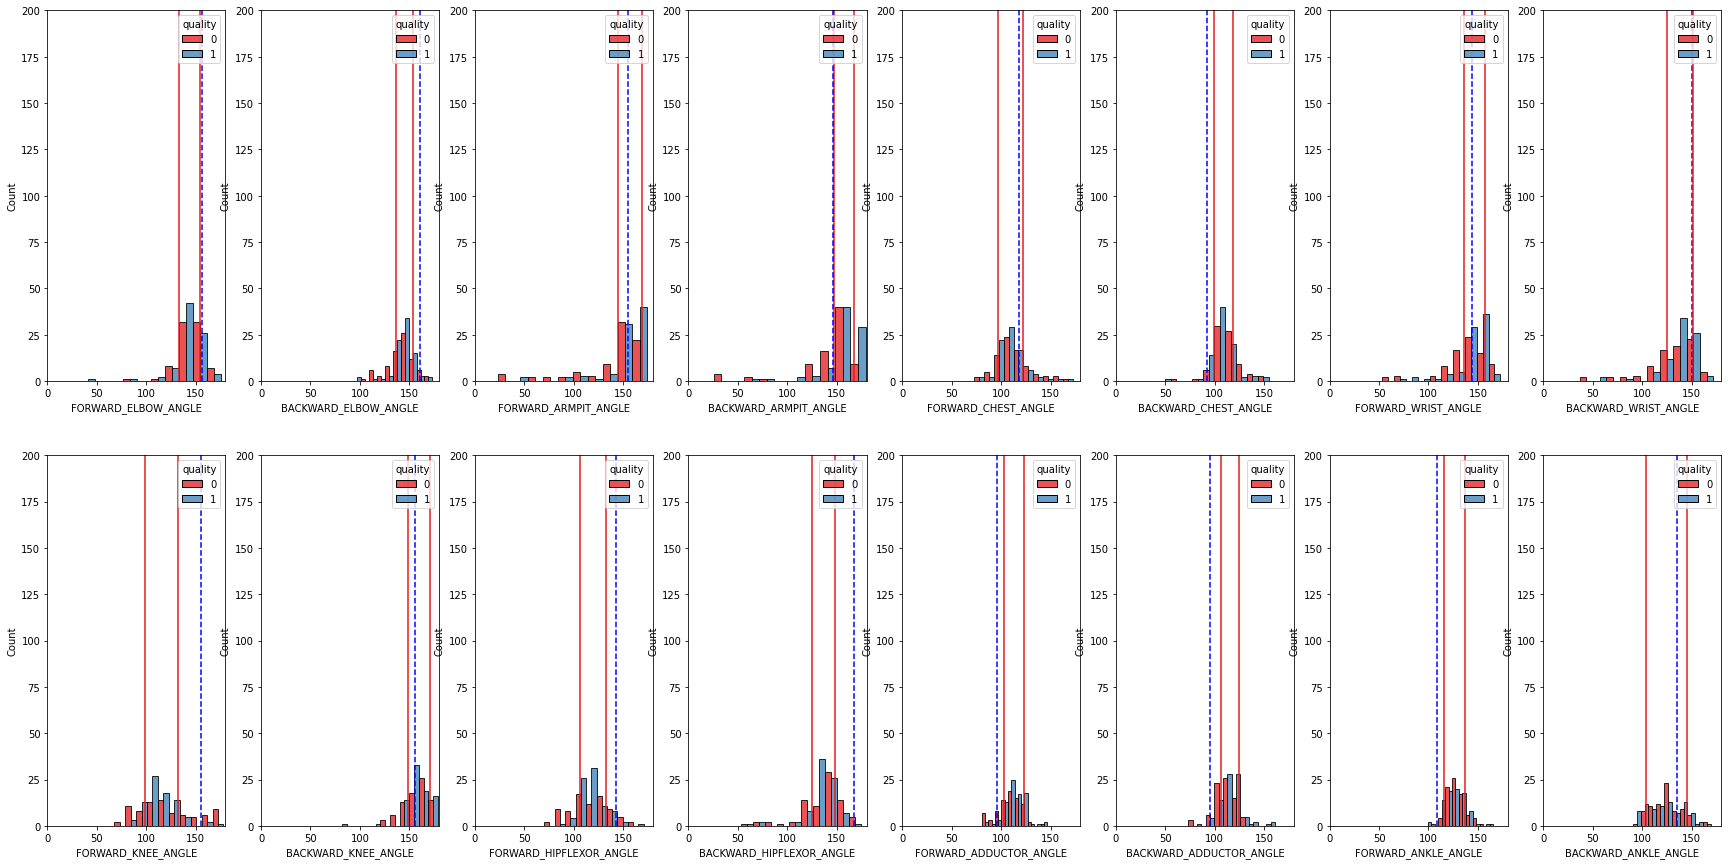

BACKWARD_ADDUCTOR_ANGLE is too small by - 11.9 degrees
FORWARD_ADDUCTOR_ANGLE is too small by - 7.5 degrees
FORWARD_ANKLE_ANGLE is too small by - 7.4 degrees
BACKWARD_CHEST_ANGLE is too small by - 6.5 degrees
BACKWARD_ARMPIT_ANGLE is too small by - 1.2 degrees
FORWARD_ELBOW_ANGLE is too large by - 2.3 degrees
BACKWARD_ELBOW_ANGLE is too large by - 6.7 degrees
FORWARD_HIPFLEXOR_ANGLE is too large by - 10.1 degrees
BACKWARD_HIPFLEXOR_ANGLE is too large by - 18.8 degrees
FORWARD_KNEE_ANGLE is too large by - 22.9 degrees


In [67]:
distribution_angles = get_angle_confidence_intervals(df, LANDMARKS, percent = .15)
plot_distribution_with_image(df, df_test, distribution_angles, LANDMARKS)

### The Nearest Neighbour Correction

In [68]:
ground_truth, ground_truth_indx = select_correct_closest_image(np_test, df)
ground_truth_img = get_annotated_img(ground_truth_indx)

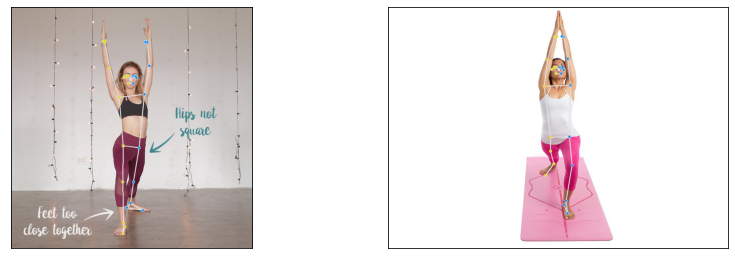

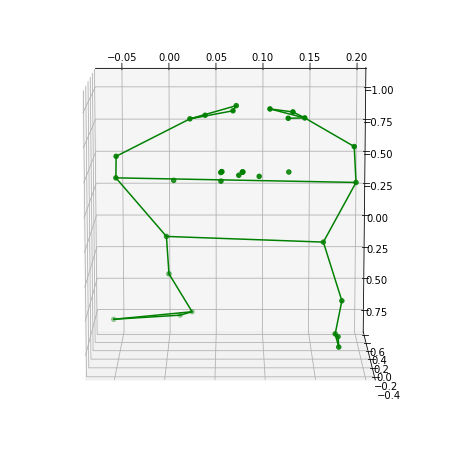

In [69]:
compare_two_figures(np.squeeze(np_test), np.squeeze(ground_truth), annotated_test_image, ground_truth_img, plot=True)

### The Generative GAN Correction

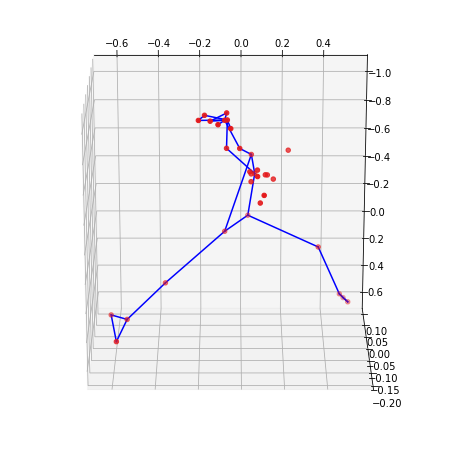

In [70]:
generate_coords_given_limb_lengths(calc_limb_lengths(np.squeeze(np_test, axis=0)), label, version=780, plot=True)